In [13]:
%load_ext autoreload
%autoreload 2
import imodels
from imodels.tree.rf_plus.rf_plus import RandomForestPlusRegressor , RandomForestPlusClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, log_loss, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import pprint
from glmnet import ElasticNet
import numpy as np
import pytorch_lightning as pl
import torch
import xgboost as xgb
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from imodels.tree.rf_plus.ppms.ppms_regression import GlmNetElasticNetRegressorPPM, GlmNetRidgeRegressorPPM, GlmNetLassoRegressorPPM
from imodels.tree.rf_plus.ppms.ppms_classification import GLMLogisticElasticNetPPM
from imodels.tree.rf_plus.data_transformations.block_transformers import MDIPlusDefaultTransformer, IdentityTransformer, CompositeTransformer, TreeTransformer
import tensorly as tl
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
import graphviz
from sklearn import tree
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression    
import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [330]:
from pandas.api.types import is_categorical_dtype

def convert_categories_to_numpy(obj):
    """
    Checks if an object is a pandas categories object.
    If so, converts it to a NumPy float array.
    If not, returns the object as is.
    """
    # Check if the object is a pandas categories object
    if isinstance(obj, pd.Categorical) or is_categorical_dtype(obj.dtype):
        # Convert to codes
        codes = obj.codes
        
        # Create a NumPy array from the codes
        arr = np.array(codes)
        
        # Cast the array to float
        arr_float = arr.astype(float)
        
        return arr_float
    else:
        return obj

In [2]:
X, y,f = imodels.get_clean_dataset("csi_pecarn",data_source="imodels")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


fetching csi_pecarn_pred from imodels


In [339]:
gbr_transform = MDIPlusDefaultTransformer(gbr.estimators_[0][0])
X_train_gbr_transform = gbr_transform.fit_transform(copy.deepcopy(X_train),center=True)
gbr_lr = LinearRegression()
gbr_lr.fit(X_train_gbr_transform.get_all_data(), y_train - np.mean(y_train))
gbr_lr_preds = gbr_lr.predict(X_train_gbr_transform.get_all_data())
print(gbr_lr_preds[:10])

[ 40.70776925 -34.41374828  46.3880488   47.26042973 -85.22913348
  12.58172706 -28.12048068 -34.85692668 -70.67935296  43.56785272]


In [351]:
X_train_gbr_transform._data_blocks[5].shape

(296, 2)

In [341]:
X_train_gbr_transform.tensorize_all_data().shape

(10, 296, 4)

In [334]:
gbr.estimators_[0][0].predict(X_train[:10])

array([ 38.38219741, -43.00950951,  38.38219741,  38.38219741,
       -69.08238884,   5.17567568, -22.67617618, -43.00950951,
       -69.08238884,  38.38219741])

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
metrics = [r2_score, mean_squared_error]
pprint.pprint(f"R2 {average_precision_score(y_test,rf.predict_proba(X_test)[:,1])}")


'R2 0.4918751318777482'


In [14]:
rf_plus_reg = RandomForestPlusClassifier(rf_model=rf,prediction_model=GLMLogisticElasticNetPPM(n_alphas=50,standardize=False,l1_ratio=0.5),center=True,fit_on="all")
                                        #GlmNetRidgeRegressorPPM(n_alphas=20,max_iter=200,tol=1e-4,standardize=False,cv=3))
rf_plus_reg.fit(X_train, y_train,n_jobs=8)


pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keywor

In [15]:
pprint.pprint(f"R2 {average_precision_score(y_test,rf_plus_reg.predict_proba(X_test))}")


'R2 -0.4515757831947771'


In [288]:
rf_plus_reg.predict(X_test)

array([ 6.61386574,  5.364272  ,  4.61451539,  3.73219657,  8.15435689,
        1.98560367,  4.28895439,  3.87048424,  4.14637551,  2.71114369,
        7.63454674,  2.04098631,  3.88290087,  4.84522212,  3.72577546,
        5.16313886,  4.62234108,  2.73652675,  5.13330948,  5.37036246,
        5.21897538,  2.30783739,  2.63252872,  6.20875764,  6.25032211,
        5.05097113,  3.61111703,  2.90862392,  0.64022212,  7.25400592,
        0.32103774,  8.17873402,  3.75913542,  5.38186742,  4.73276125,
        3.24590448,  7.74072143,  7.67946929,  5.61560278,  5.59507658,
        4.18816031,  5.43764245,  4.6496616 ,  6.17140282,  0.49937229,
        3.78862126,  5.21379152,  3.72522973,  4.17538869, -0.15389314,
        0.476042  ,  5.20108642,  6.97721538,  4.57239606,  0.03230882,
        5.07683404,  4.38282092,  8.45427934,  4.61211387,  3.17541514,
        5.45522339,  5.0502946 ,  4.11879441,  4.94539471,  7.85516565,
        1.70309513,  4.38999737,  8.11507591,  7.90910097,  0.74

In [250]:
a = rf_plus_reg.transformers_[0]


In [247]:

for i in range(X_train.shape[1]):
    print(rf_plus_reg.transformers_[0]._transform_one_feature(X_train,i).shape)


#X_transformed_train = rf_plus_reg.transformers_[0].fit_transform(X_train).get_all_data()
#X_transformed_train.shape
#X_transformed_test = rf_plus_reg.transformers_[0].transform(X_test).get_all_data()


(2798, 12)
(2798, 31)
(2798, 32)
(2798, 32)
(2798, 45)
(2798, 52)
(2798, 39)
(2798, 45)


In [278]:
xgb_m = xgb.XGBClassifier()
xgb_m.fit(X_train, y_train)
pprint.pprint(f"R2 {r2_score(y_test,xgb_m.predict_proba(X_test)[:,1])}")

'R2 -2.350750072885908'


In [279]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
r2_score(xgb_reg.predict(X_test),y_test)

0.055677809109055065

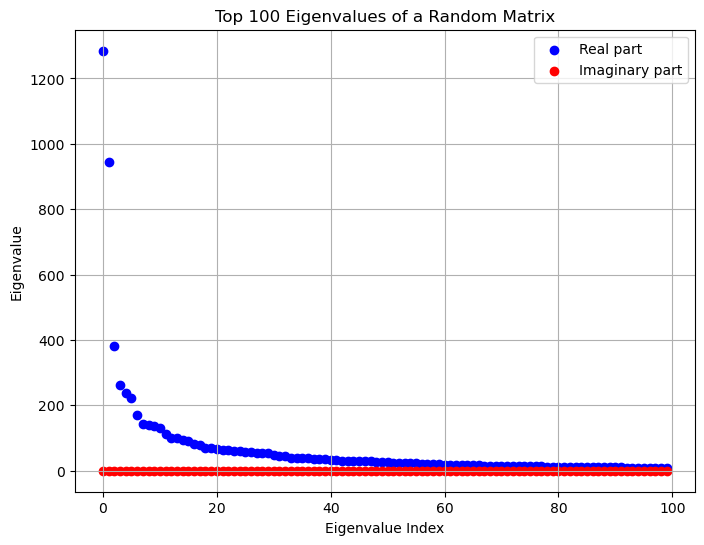

In [103]:
eigenvalues, eigenvectors = np.linalg.eig(X_transformed_test.T @ X_transformed_test)

# Sort the eigenvalues in descending order
sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]

# Plot the top 100 eigenvalues
top_n = 100
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(top_n), np.real(sorted_eigenvalues[:top_n]), color='b', label='Real part')
plt.scatter(np.arange(top_n), np.imag(sorted_eigenvalues[:top_n]), color='r', label='Imaginary part')
plt.title(f'Top {top_n} Eigenvalues of a Random Matrix')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.grid(True)
plt.show()


In [34]:

class ElasticLinear(pl.LightningModule):
    def __init__(
        self, loss_fn, n_inputs: int = 1, learning_rate=0.05, l1_lambda=0.05, l2_lambda=0.05
    ):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss_fn = loss_fn
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.output_layer = torch.nn.Linear(n_inputs, 1)
        self.train_log = []
        self.val_log = []

    def forward(self, x):
        outputs = self.output_layer(x)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def l1_reg(self):
        l1_norm = self.output_layer.weight.abs().sum()

        return self.l1_lambda * l1_norm

    def l2_reg(self):
        l2_norm = self.output_layer.weight.pow(2).sum()
        
        return self.l2_lambda * l2_norm

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y) + self.l1_reg() + self.l2_reg()
        self.log("loss", loss)
        self.train_log.append(loss.detach().numpy())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = self.loss_fn(y_hat, y) 
        self.log("val_loss", val_loss)
        self.val_log.append(val_loss.detach().numpy())
        return val_loss
    
    def on_fit_start(self):
        self.device = torch.device("mps" if torch.cuda.is_available() else "cpu")
        self.to(self.device)  # Move the model to the device




In [35]:
x_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train[:,np.newaxis],dtype=torch.float32)
x_test_t = torch.tensor(X_test, dtype=torch.float32 )
y_test_t = torch.tensor(y_test[:, np.newaxis],dtype=torch.float32)

dataset_train = TensorDataset(x_train_t, y_train_t)
dataloader_train = DataLoader(dataset_train, batch_size=256, shuffle=True,num_workers=4)
dataset_val = TensorDataset(x_test_t, y_test_t)
dataloader_val = DataLoader(dataset_val, batch_size=x_test_t.shape[0], shuffle=False)

In [39]:
#from pytorch_lightning.loggers import TensorBoardLogger

model = ElasticLinear(
    loss_fn=torch.nn.MSELoss(),
    n_inputs=X_train.shape[1],
    l1_lambda=0.0,
    l2_lambda=0.0,
    learning_rate=0.05,
)


# fit model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, dataloader_train, dataloader_val)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

#plot_convergence(model.train_log)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params
-----------------------------------------
0 | loss_fn      | MSELoss | 0     
1 | output_layer | Linear  | 9     
-----------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [51]:
def plot_convergence(train_loss):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(train_loss)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    # set log scale 
    ax.set_yscale('log')
    fig.show()



FigureCanvasAgg is non-interactive, and thus cannot be shown


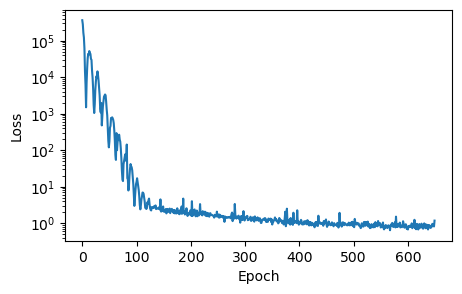

In [52]:
plot_convergence(model.train_log)


FigureCanvasAgg is non-interactive, and thus cannot be shown


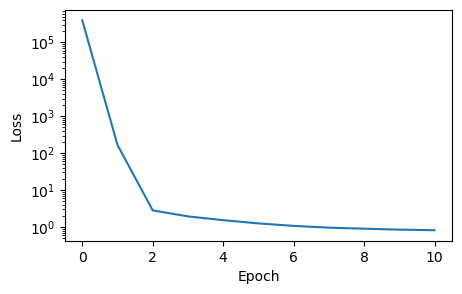

In [53]:
plot_convergence(model.val_log)


In [54]:
print(torch.backends.mps.is_available())


False


In [60]:
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")

Is MPS (Metal Performance Shader) built? False


In [59]:
torch.backends.mps.is_available()
#pytorch version
#torch.__version__

False